In [1]:
import torch
import numpy as np
import random
import os
from functools import partial

We are importing `dagger` as `dg` to clearly label all parts of the code that belong to the library and differentiate them from other user-defined functionalities.

In [2]:
import dagger as dg
from types import MethodType
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

Define a seed-setting function to be used later for reproducibility purposes

In [3]:
def set_reproducible_seed(seed):

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
import logging
logging.basicConfig(level=logging.DEBUG)

Since `dagger` only provides the experiment orchestration skeleton, the definition of an experiment, of the actions that allow to transition from a state to another, and all custom functionalities that directly depend on the nature of the experiment that one wants to run remain up to the user to define, without `dagger` imposing a particular way to express those steps in a machine learning pipeline. This enables code reuse and maximum flexibility for the user.

In most applications, initializing an experiment might mean initializing a model, an optimizer, and a dataloader, for example.

In [5]:
# Any canonical utility function to fetch data, initialize models and optimizers
# can be incorporated into the state initialization. For example, here's a function that could be
# found in common ML experiment code to get MNIST dataloaders.

def get_dataloaders(dataset, root, train_batch_size, test_batch_size, seed, num_workers=0):
    # this example only supports MNIST but can be easily extended to other datasets
    if dataset.lower() == "mnist":
        transf = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        train_dataset = datasets.MNIST(
            root=root,
            train=True,
            download=True,
            transform=transf,
        )
        test_dataset = datasets.MNIST(
            root=root,
            train=False,
            download=True,
            transform=transf,
        )

        def _worker_init_fn(worker_id, seed):
            # for reproducibility
            np.random.seed(int(seed))

        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=train_batch_size,
            shuffle=True,
            num_workers=num_workers,
            worker_init_fn=partial(_worker_init_fn, seed=seed),
        )
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=test_batch_size,
            shuffle=False,
            num_workers=num_workers,
            worker_init_fn=partial(_worker_init_fn, seed=seed),
        )
        return train_loader, test_loader
    else:
        raise ValueError('Only value currently supported for `dataset` is "mnist"')
            


class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_model(model_name):
    # this example only supports LeNet but can be easily extended to other models
    if model_name.lower() == "lenet":
        return LeNet()
    else:
        raise ValueError('Only value currently supported for `model_name` is "lenet"')
    

def get_optimizer(optimizer_name, parameters, **kwargs):
    # this example only supports adam and sgd but can be easily extended to other optimizers
    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(parameters, **kwargs)
    elif optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(parameters, **kwargs)
    else:
        raise ValueError("`optimizer_name` must be one of {'adam', 'sgd'}")
    return optimizer

With all the generic dataset, model, and optimizer fetching functions above, which are often found in many ML pipelines, we can now enter the `dagger` world and create a custom experiment state type called `MyExperimentState`, which will subclass `dagger`'s `ExperimentState` to specify what it means to be a new state in our own experiments.

Specifically, we will have to specify the properties that define and distringuish a state from another, as well as an `initialize_state` method with the instructions on how to generate a state from scratch.

In [6]:
class MyExperimentState(dg.ExperimentState):
    
    # properties that will be serialized with the state
    PROPERTIES = [
        "dataset_name",
        "model_name",
        "optimizer_name",
        "dataloader_hparams",
        "optimizer_hparams",
        "seed",
    ]

    # properties that will not be serialized with the state
    NONHASHED_ATTRIBUTES = [
        "train_dataloader",
        "test_dataloader",
        "model",
        "optimizer",
    ]
    
    def __init__(self, parent_sha, experiment_object):
        super().__init__(parent_sha, experiment_object)

    def initialize_state(self, init_schema=None, parallel=False, **kwargs):
        """Initializing a state, in this example, means instantiating the right model, dataloaders, and optimizer.
        """
        self.seed = kwargs.get("seed", 0)
        set_reproducible_seed(self.seed)  # function defined at the top of the notebook

        # Instantiate dataloaders
        self.train_dataloader, self.test_dataloader = get_dataloaders(**self.dataloader_hparams)

        # Instantiate model
        self.model = get_model(self.model_name)

        # Instantiate optimizer
        self.optimizer = get_optimizer(
            self.optimizer_name,
            self.model.parameters(),
            **self.optimizer_hparams,
        )

Now that we have defined a new type of experiment state that is unique to the experiments we want to run, let's initialize an experiment by specifying the type of experiment states it will hold and the directory where they will be stored.

In [7]:
exp = dg.Experiment(directory='./example/', state_class=MyExperimentState)

In [8]:
exp.directory

PosixPath('/private/home/michela/dagger/tutorials/example')

The experiment is currently an empty container, as no instructions have been provided to initialize the experiment

In [9]:
exp.leaves

{}

In [10]:
exp.root is None

True

In [11]:
exp.graph is None

True

The experiment container has been created, but it still doesn't contain any experiment state. Let's start by creating a root, from which all other experiment states will originate. This means creating an instance of `MyExperimentState`. Instead of doing it manually in an ephemeral way, we can use the `.spawn_new_tree` method of a `dagger` `Experiment`.

In [12]:
seed = 123

In [13]:
dataloader_hparams = {
    "dataset": "mnist",
    "root": "~/data/",
    "train_batch_size": 64,
    "test_batch_size": 64,
    "num_workers": 0,
    "seed": seed,
}

optimizer_hparams = {"lr": 0.01}

# Let the Experiment `exp` know what model, dataset, optimizer (and all their hyperparams) to use to generate
# the root state.
x = exp.spawn_new_tree(
    dataset_name=dataloader_hparams["dataset"],
    model_name="lenet",
    optimizer_name="sgd",
    dataloader_hparams=dataloader_hparams,
    optimizer_hparams=optimizer_hparams,
    seed=seed,
)

INFO:dagger:No cached state at: /private/home/michela/dagger/tutorials/example/62bee8c1ddf044584494779cf50e344a-root
INFO:dagger:Root state unsaved - saving now
DEBUG:dagger:Saving to: /private/home/michela/dagger/tutorials/example/62bee8c1ddf044584494779cf50e344a-root


In [14]:
exp.root

MyExperimentState(sha=62bee8c1ddf044584494779cf50e344a-root, tags=[])

In [15]:
# ^^this should also be added to the nodes and leaves??

In [16]:
exp.experiment_arguments

{'dataset_name': 'mnist',
 'model_name': 'lenet',
 'optimizer_name': 'sgd',
 'dataloader_hparams': {'dataset': 'mnist',
  'root': '~/data/',
  'train_batch_size': 64,
  'test_batch_size': 64,
  'num_workers': 0,
  'seed': 123},
 'optimizer_hparams': {'lr': 0.01},
 'seed': 123}

In [17]:
exp.root.model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
exp.root.train_dataloader

In [19]:
exp.root.sha()

'62bee8c1ddf044584494779cf50e344a-root'

In [20]:
exp.root.seed

123

In [21]:
exp.root.path

PosixPath('/private/home/michela/dagger/tutorials/example/62bee8c1ddf044584494779cf50e344a-root')

Now that we have initialized a shared root for all experiments, we can start deriving child states from it depending on the scientific questions we are interested in asking about the model. To generate a child state, we need to act on the root with a `Recipe` which will specify the actions that turn the root into a new state (i.e. a new instance of `MyExperimentState` attached to the same `Experiment`). The `exp` object will track provenance of all experiment states.

Say, for example, that the experiment we are interested in running here is the comparison between training the full model versus training a randomly pruned version of the same model. We will need two `Recipe`s: one that trains the model, one that prunes and then trains the model.

In [22]:
# For reproducibility purposes, let's go through the intermediate step of creating a SeededRecipe for seed handling
class SeededRecipe(dg.Recipe):
    def __call__(self, experiment_state):
        self.experiment_object = experiment_state.experiment_object
        if not hasattr(self, "seed") or self.seed is None:
            self.seed = self.experiment_object.root.seed
        return super().__call__(experiment_state)

    def set_seed(self):
        set_reproducible_seed(self.seed)  # defined at the top of the notebook

In [23]:
class TrainRecipe(SeededRecipe):

    PROPERTIES = ["nb_epochs", "seed"]

    def __init__(self, nb_epochs, seed=None):
        self.nb_epochs = nb_epochs
        self.seed = seed

    def run(self, new_state):
        self.set_seed()
        new_state.model.train()
        loss_func = torch.nn.CrossEntropyLoss()

        # Training loop
        for epoch_n in range(self.nb_epochs):
            print('Epoch: {}'.format(epoch_n))
            for batch_n, (X, y) in enumerate(new_state.train_dataloader):
                # train
                new_state.optimizer.zero_grad()
                yhat = new_state.model(X)
                loss = loss_func(yhat, y)
                loss.backward()
                new_state.optimizer.step()

        return new_state

In [24]:
class PruneRecipe(SeededRecipe):

    PROPERTIES = ["schema", "seed"]

    def __init__(self, schema, seed=None):
        self.schema = schema
        self.seed = seed

    def run(self, new_state):
        self.set_seed()
        
        def _prune_model(model, pruning_schema):
            """Use the instructions in the pruning schema to apply the correct pruning
            function to the correct tensor within the correct module.
            This uses `named_modules` to get the module object.
            """
            for (module_name, tensor_name), pruning_fn in pruning_schema.items():
                # use the module name to extract the module from the model
                if module_name not in dict(model.named_modules()):
                    raise KeyError(
                        "Module {} not found. Available modules: {}".format(
                            module_name, dict(model.named_modules()).keys()
                        )
                    )
                module = dict(model.named_modules())[module_name]
                # now that we have both module and tensor_name, we prune them
                pruning_fn(module, tensor_name)

        _prune_model(
            model=new_state.model,
            pruning_schema=self.schema,
        )
        return new_state

As defined above, a PruningRecipe will need a pruning schema that will provide instructions on how to prune each parameter in the model. Since we only want to prune weights (and not biases) at random by removing 50% of their connections, the schema below will do.

In [25]:
import torch.nn.utils.prune as prune
pruning_schema = {
    ("conv1", "weight"): partial(prune.random_unstructured, amount=0.5),
    ("conv2", "weight"): partial(prune.random_unstructured, amount=0.5),
    ("fc1", "weight"): partial(prune.random_unstructured, amount=0.5),
    ("fc2", "weight"): partial(prune.random_unstructured, amount=0.5),
    ("fc3", "weight"): partial(prune.random_unstructured, amount=0.5),
}

In [26]:
a = TrainRecipe(nb_epochs=1)(x)

In [27]:
b = TrainRecipe(nb_epochs=1)(
        PruneRecipe(schema=pruning_schema)(x)
)

In [28]:
exp.leaves

{UUID('73613848-ed4d-413c-9f50-07b41663172f'): Delayed('run_recipe-667bab97-73e8-4a0d-8004-b4b73b40b1c2'),
 UUID('542e2e6b-568d-491a-9f79-25746665ad68'): Delayed('run_recipe-7b012b9b-bea2-4bb0-b803-9187af7f9aaf')}

In [29]:
exp.run()

INFO:dagger:No cached state at: /private/home/michela/dagger/tutorials/example/48d6fa140909a216a8bb4cf557ac922c
DEBUG:dagger:Saving to: /private/home/michela/dagger/tutorials/example/48d6fa140909a216a8bb4cf557ac922c
INFO:dagger:No cached state at: /private/home/michela/dagger/tutorials/example/22f54778d497611f21fa6f998f270572


Epoch: 0


DEBUG:dagger:Saving to: /private/home/michela/dagger/tutorials/example/22f54778d497611f21fa6f998f270572
INFO:dagger:No cached state at: /private/home/michela/dagger/tutorials/example/d296b6e17e99ef92fd6c728507198d69


Epoch: 0


DEBUG:dagger:Saving to: /private/home/michela/dagger/tutorials/example/d296b6e17e99ef92fd6c728507198d69


# Analysis

Now that the experiment has been run, one could even safely close and restart this notebook to simulate the experience of analyzing the results at a later point in time.

The key point of `dagger` is that it powers quick analysis of complex experiment results through an intuitive API that allows users to visualize and filter experiment states by tag, level, etc.

In [30]:
import dagger as dg

Restore an experiment from disk by specifying its location and the type of experiment states it contains

In [33]:
exp = dg.Experiment.restore(directory='./example/', state_class=MyExperimentState)

Draw the experiment tree for visual inspection

DEBUG:graphviz.files:write 949 bytes to './example/graph'
DEBUG:graphviz.backend:run ['dot', '-Tpng', '-O', 'graph']
DEBUG:graphviz.files:delete './example/graph'


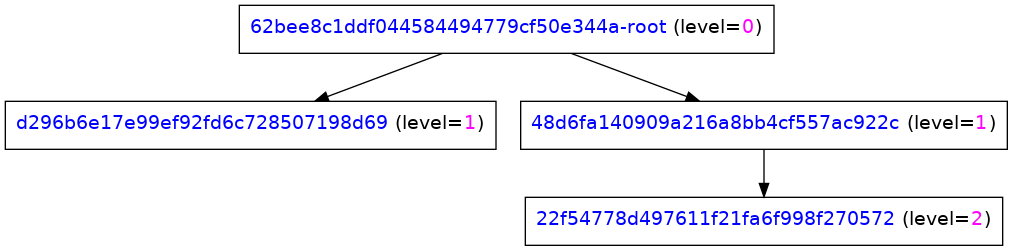

In [34]:
exp.graph.draw(filename='./example/graph', format='png', view=True)

This tree clearly shows all experiment states in the experiment with their associated SHAs. The root is easy to identify (level=0). All other experiment states originate from the root and are connected in a DAG-like fashion.
One one side we have the state that corresponds to simply training the model that was initialized in the root; on the other side, we have a state that corresponds to first pruning the model that was initialized in the root, and then training that pruned model.

It is true, however, that, unless one already knows the exact logic that went into the generation of these experiment states, it is very hard from this visualization to know exactly what each state represents. Thankfully, `dagger` easily solves the problem by letting you add `tags` to each state to easily identify and filter them. This can be achieved by simply encapsulating the recipes with `with` statements:

In [35]:
with exp.tag("train1epoch"):
    c = TrainRecipe(nb_epochs=1, seed=123)(exp.root.to_promise())
    
# This new node will be attached to the root, in this example, but can be attached to any other node
# Note: remember to transform the node to a dagger.ExperimentStatePromise so that dask can run the new graph

In [36]:
exp.run()

INFO:dagger:No cached state at: /private/home/michela/dagger/tutorials/example/048559c33aa862acc226c32a553bab4b


Epoch: 0


DEBUG:dagger:Saving to: /private/home/michela/dagger/tutorials/example/048559c33aa862acc226c32a553bab4b


Now that the new node has been attached, let's restore and replot the experiment to see how this need node (and its `tags`) appear

DEBUG:graphviz.files:write 1243 bytes to './example/graph'
DEBUG:graphviz.backend:run ['dot', '-Tpng', '-O', 'graph']
DEBUG:graphviz.files:delete './example/graph'


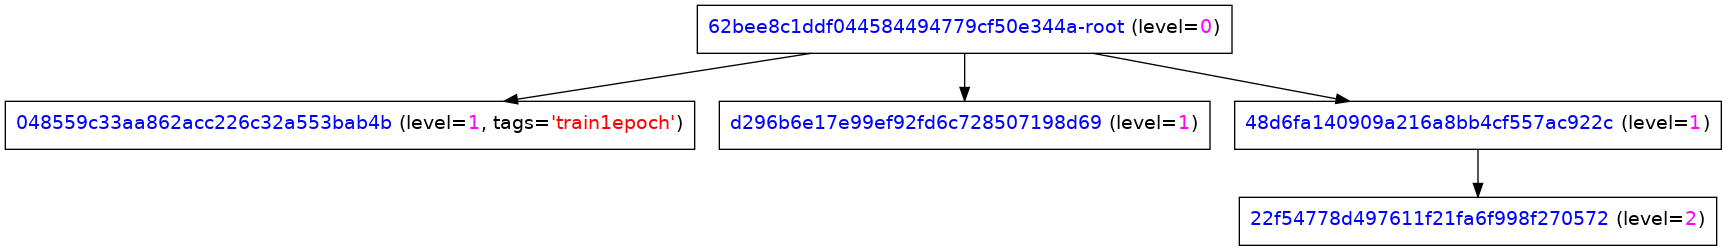

In [37]:
exp = dg.Experiment.restore(directory='./example/', state_class=MyExperimentState)
exp.graph.draw(filename='./example/graph', format='png', view=True)

Now that we have a full experiment tree, as an example analysis, let's evaluate some simple metrics (such as accuracy) for the models at all leaf states. First, define the evaluation function:

In [38]:
def eval_model(model, loader, eval_fn=None, device=torch.device("cpu")):
    """Main evaluation loop for a model. Allows for configurable metric."""

    # Default eval metric: accuracy
    if not eval_fn:
        def eval_fn(y_true, y_pred):
            return (y_pred.argmax(-1) == y_true).sum().item()

    training = model.training

    # Eval loop
    model.eval()
    total_examples = len(loader.dataset)
    total_metric = 0
    model = model.to(device=device)

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device)
            y = y.to(device=device)
            y_pred = model(X)

            batch_metric = eval_fn(y_true=y, y_pred=y_pred)
            if hasattr(batch_metric, "item"):
                batch_metric = batch_metric.item()
            total_metric += batch_metric

    # Reset the model to training mode if that's the mode it was initially found in
    if training:
        model.train()

    return float(total_metric) / total_examples

Second, identify all leaf states by looping through the experiment's `edge_map` and selecting the nodes without children (the leaves, by definition).

In [39]:
leaves = [node for node, children in exp.graph.edge_map.items() if not children]

In [40]:
# Reload all leaves into memory one by one and evaluate the accuracy of their models
for node, state in exp.graph.node_map.items():
    if node in leaves:
        with state.lazy_load():
            print('Node {}, Accuracy {}'.format(
                node,
                eval_model(state.model, state.test_dataloader, device=torch.device("cuda"))
            ))

INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/22f54778d497611f21fa6f998f270572! Safely loading existing state.
INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/d296b6e17e99ef92fd6c728507198d69! Safely loading existing state.


Node 22f54778d497611f21fa6f998f270572, Accuracy 0.1135


INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/048559c33aa862acc226c32a553bab4b! Safely loading existing state.


Node d296b6e17e99ef92fd6c728507198d69, Accuracy 0.8914
Node 048559c33aa862acc226c32a553bab4b, Accuracy 0.8914


As a sanity check, the states with the tag and without the tag that are otherwise identical (1 epoch of training from the same initialization) return the same accuracy.

The code in the previous cell can also be expressed by making use of a `dagger.Function`:

In [41]:
evaluate_acc = dg.Function(
    lambda s: print('Node {}, Accuracy {}'.format(
        s.sha(),
        eval_model(s.model, s.test_dataloader, device=torch.device("cuda"))
    ))
)
    
for node, state in exp.graph.node_map.items():
    if node in leaves:
        evaluate_acc(state.to_promise())
exp.run()

INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/048559c33aa862acc226c32a553bab4b! Safely loading existing state.
INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/22f54778d497611f21fa6f998f270572! Safely loading existing state.


Node 048559c33aa862acc226c32a553bab4b, Accuracy 0.8914


INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/d296b6e17e99ef92fd6c728507198d69! Safely loading existing state.


Node 22f54778d497611f21fa6f998f270572, Accuracy 0.1135
Node d296b6e17e99ef92fd6c728507198d69, Accuracy 0.8914


Let's dig a bit deeper into all of the functionalities provided by `dagger` at the analysis stage.

In [42]:
type(exp.graph)

dagger.dag.StaticExperimentTree

The experiment graph is an instance of the `dagger` `StaticExperimentTree` class, which enables easy inspection of all experimental dependencies. Let's see how.

The list of all experiment states in the tree is wrapped in the `dagger` `NodeSet` inner class which allows for compositional filtering of states in the tree by `tag`.

In [43]:
exp.graph.nodes

[MyExperimentState(sha=62bee8c1ddf044584494779cf50e344a-root, tags=[]),
 MyExperimentState(sha=48d6fa140909a216a8bb4cf557ac922c, tags=[]),
 MyExperimentState(sha=22f54778d497611f21fa6f998f270572, tags=[]),
 MyExperimentState(sha=d296b6e17e99ef92fd6c728507198d69, tags=[]),
 MyExperimentState(sha=048559c33aa862acc226c32a553bab4b, tags=['train1epoch'])]

In [44]:
type(exp.graph.nodes)

dagger.dag.StaticExperimentTree.NodeSet

In [45]:
exp.graph.root  # easily access the root

MyExperimentState(sha=62bee8c1ddf044584494779cf50e344a-root, tags=[])

In [46]:
exp.graph.node('62bee8c1ddf044584494779cf50e344a-root')  # select state by sha

MyExperimentState(sha=62bee8c1ddf044584494779cf50e344a-root, tags=[])

In [47]:
exp.graph.nodes.filter('train*epoch')  # filter states by tag

[MyExperimentState(sha=048559c33aa862acc226c32a553bab4b, tags=['train1epoch'])]

In [48]:
exp.graph.nodes_at_distance(1)  # filter states by distance from the root

[MyExperimentState(sha=48d6fa140909a216a8bb4cf557ac922c, tags=[]),
 MyExperimentState(sha=d296b6e17e99ef92fd6c728507198d69, tags=[]),
 MyExperimentState(sha=048559c33aa862acc226c32a553bab4b, tags=['train1epoch'])]

DEBUG:graphviz.backend:run ['dot', '-Tsvg']


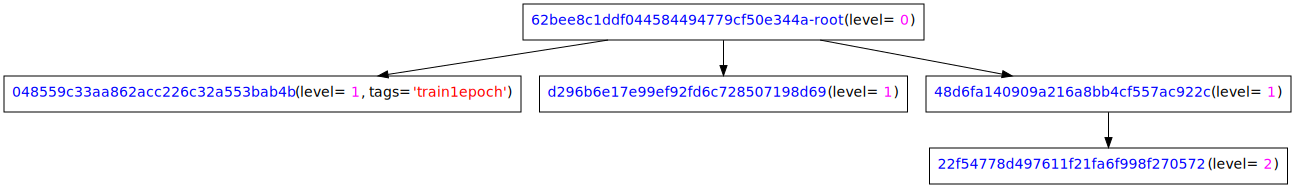

In [49]:
exp.graph.to_graphviz()  # plot experiment tree without saving

It is worth noting that, at this point, **none of the experiments (with related models, masks, dataloaders, etc) is fully loaded into memory**. If that were the case, no large experiments with multiple states could easily be analyzed due to memory constraints. Instead, only their minimal ("slim") version is currently loaded. This allows us to access only the basic info needed to reconstruct the tree dependencies (children, parents, shas, tags). Let's pick any state and call it `s`.

In [50]:
s = exp.graph.nodes[0]
s.slim_loaded

True

In [51]:
s.__dict__

{'parent_sha': None,
 'slim_sha': '62bee8c1ddf044584494779cf50e344a-root',
 'slim_loaded': True,
 'tags': [],
 'experiment_object': <dagger.dag.Experiment at 0x7f0060940160>,
 'children': {MyExperimentState(sha=048559c33aa862acc226c32a553bab4b, tags=['train1epoch']),
  MyExperimentState(sha=48d6fa140909a216a8bb4cf557ac922c, tags=[]),
  MyExperimentState(sha=d296b6e17e99ef92fd6c728507198d69, tags=[])},
 'parent': None}

To fully load an experiment state (node) in memory for full analysis, we need to restore it:

In [52]:
s.restore()

INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/62bee8c1ddf044584494779cf50e344a-root! Safely loading existing state.


True

In [53]:
s.slim_loaded  # it is now fully loaded

False

In [54]:
s = exp.graph.nodes[0]
s.__dict__

{'parent_sha': None,
 'from_cache': True,
 'root_state': True,
 'save_pre_hooks': [],
 'save_post_hooks': [],
 'load_post_hooks': [],
 '_recipe': None,
 'slim_loaded': False,
 'slim_sha': None,
 'tags': [],
 'dataset_name': 'mnist',
 'model_name': 'lenet',
 'optimizer_name': 'sgd',
 'dataloader_hparams': {'dataset': 'mnist',
  'root': '~/data/',
  'train_batch_size': 64,
  'test_batch_size': 64,
  'num_workers': 0,
  'seed': 123},
 'optimizer_hparams': {'lr': 0.01},
 'seed': 123,
 'train_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7f0060ef7160>,
 'test_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7f0159443240>,
 'model': LeNet(
   (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
   (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
   (fc1): Linear(in_features=400, out_features=120, bias=True)
   (fc2): Linear(in_features=120, out_features=84, bias=True)
   (fc3): Linear(in_features=84, out_features=10, bias=True)
 ),
 'optimizer': SGD (
 Param

To remove the state from memory once you're done using it, make sure to deflate it:

In [55]:
s.deflate()

True

In [56]:
s.slim_loaded

True

We suggest using this with context managers (`with` statements, or the `dagger` provided `iterator`):

In [57]:
for state in exp.graph.nodes.iterator:
    print(state.slim_loaded)

INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/62bee8c1ddf044584494779cf50e344a-root! Safely loading existing state.
INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/48d6fa140909a216a8bb4cf557ac922c! Safely loading existing state.
INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/22f54778d497611f21fa6f998f270572! Safely loading existing state.
INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/d296b6e17e99ef92fd6c728507198d69! Safely loading existing state.


False
False
False


INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/048559c33aa862acc226c32a553bab4b! Safely loading existing state.


False
False


In fact, a safer way to restore the state, instead of using `restore` and then having to remember to `deflate`, is to `lazy_load` the state (which is what `iterator` above is making use of):

In [58]:
s.slim_loaded

True

In [59]:
with s.lazy_load():
    print(s.slim_loaded)

INFO:dagger:State already exists at /private/home/michela/dagger/tutorials/example/62bee8c1ddf044584494779cf50e344a-root! Safely loading existing state.


False


In [60]:
s.slim_loaded

True